In [1]:
import MeCab

import japanize_matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import neologdn
import re

from functools import reduce
from operator import add

from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default = 'iframe'

from plotnine import ggplot, aes, geom_histogram, geom_bar, scale_y_log10, theme, element_text, coord_flip, scale_x_discrete

from tqdm import tqdm

In [2]:
# データを DataFrame として読み込み
df = pd.read_json('../../data/fc2b/fc2b.json')
df.sample(5)

,blog,entry,genre_id,genre_name,subgenre_id,subgenre_name,text,title,toxicity
1331,meitarou.blog.fc2.com,blog-entry-8587.html,18,ペット,157,猫,こたつからチョウナン君の足が出ていた。飼い主 「ああ、その足は、姪太郎、邪魔だな」姪太郎 「...,思い切りnya! - 姪太郎日記～ネコとムスコのいる生活～,0
17430,jewelrydays00.blog.fc2.com,blog-entry-2918.html,14,恋愛,131,両思い,楽しかった旅を思い出していた Yukiへのお土産を渡した時の喜んだ顔はしゃいだビュッフェ 時...,思い出して - Diary,0
10422,noasong.blog.fc2.com,blog-entry-6435.html,8,音楽,27,邦楽,プロフィール\n \n シンガーソングライター・ボイスト...,Pink Floyd Trips 原始神母 『The Division Bell』30th ...,0
21407,empowermentlab.blog97.fc2.com,blog-entry-514.html,28,学問・文化・芸術,279,絵画,"Hello everyone! I am Yuri Nurdiantami, a third...",Empowerment Sciences - エンパワメント科学 Fair Toys Dis...,0
26559,d2pqjifo90m6.blog.fc2.com,blog-entry-334.html,22,ブログ,23,その他,プロフィール\n \n 『🥰たのしいコトだいすき🥰』♬...,『おばんそわ』岸田奈美さん←さいっこう💛 | ブログ,0


In [3]:
# TEXT から MeCab で内容語のみ抽出する
mecab = MeCab.Tagger()

all_tokens = []
for text in tqdm(df["text"].values):
    text = neologdn.normalize(text).strip()
    parsed_text = mecab.parse(text)
    if parsed_text:
        tokens = [t[0] for t in re.findall(r"^(.+?)\s+(名詞|動詞|形容詞|副詞)", parsed_text, flags=re.MULTILINE)]
        all_tokens.append(" ".join(tokens))
    else:
        all_tokens.append("")

df["tokens"] = all_tokens

df = df[df["tokens"] != ""]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29511/29511 [01:46<00:00, 277.26it/s]


In [4]:
df[['toxicity', 'genre_name', 'title', 'tokens']].sample(5)

,toxicity,genre_name,title,tokens
8009,0,学問・文化・芸術,オホーツクの博物館を訪問 - 北大野外鳥類学研究室ブログ,オホーツク 博物館 訪問 髙木 研 3 年 安田 理学部 生物 科学 科 ( 生物 学 ) ...
29214,0,趣味・実用,混結 - 鉄道模型趣味の備忘録,東急 5000 系 最後 仕上げ 車 番 貼り 付け GM 製 インレタ 3000 系 セッ...
23563,0,スポーツ,RS.BBC.+R.C ☆RS.BBC.の紹介☆ （メンバー募集中！）,RS . BBC .( R . C 兄妹 チーム ) 杉並 区 中心 活動 し いる バスケ...
25761,0,心と身体,あれもこれも冬至の毒だし | 心とからだを美しくする方法,並木 さん いわく 今年 冬至 例年 以上 パワフル 冬至 境 エネルギー ガラリ ! 変わ...
5778,0,趣味・実用,山遊楽会(サフラン)・大阪府岳連盟所属の山岳会 |2024.12.8 鬼ヶ牙～臼杵ヶ岳周回,涸れ 沢 沿う 道 入る すぐ フィックス ロープ つい 岩場 ザレ 場 現れる 花崗岩 岩...


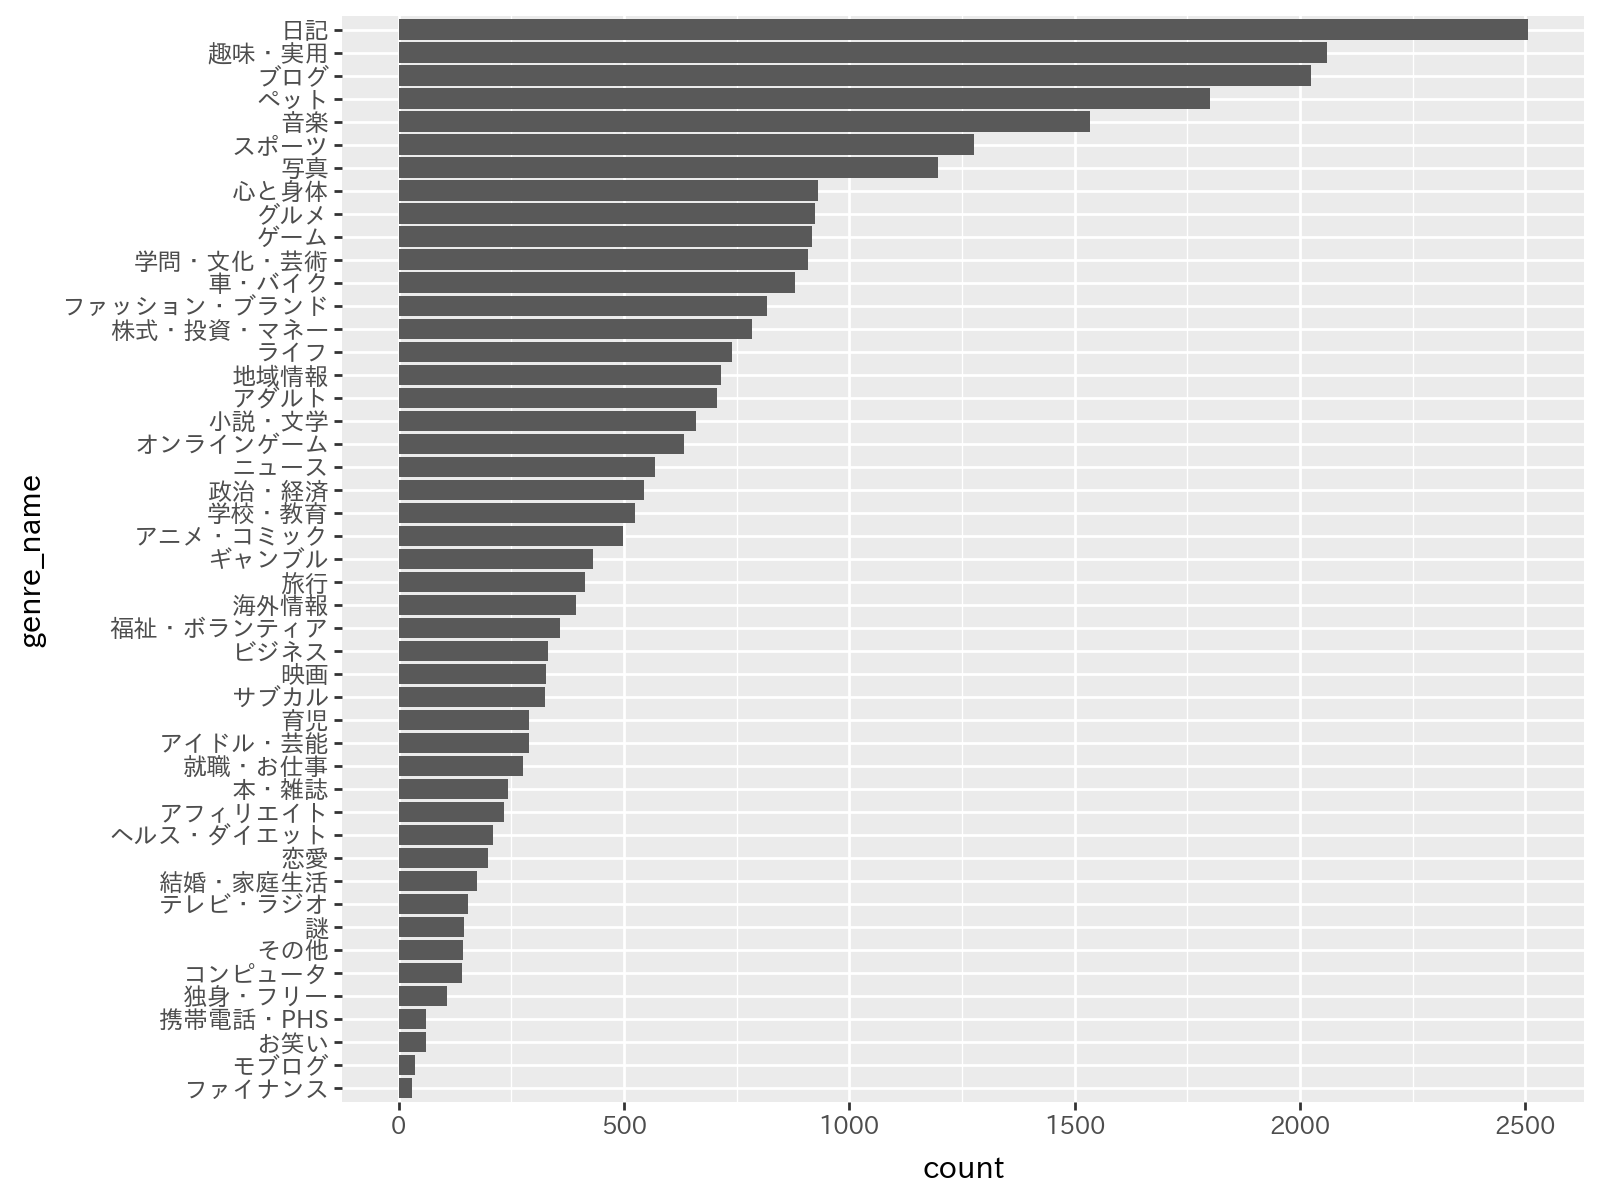

In [5]:
#　各ジャンルの記事数

## plotnine
# Determine order and create a categorical type
# Note that value_counts() is already sorted
genre_name_list = df["genre_name"].value_counts().index.tolist()[::-1]

(
    ggplot(df, aes(x='genre_name'))
    + geom_bar()
    + scale_x_discrete(limits=genre_name_list)
    + theme(text=element_text(family='IPAexGothic'), figure_size=(8, 6))
    + coord_flip()
)

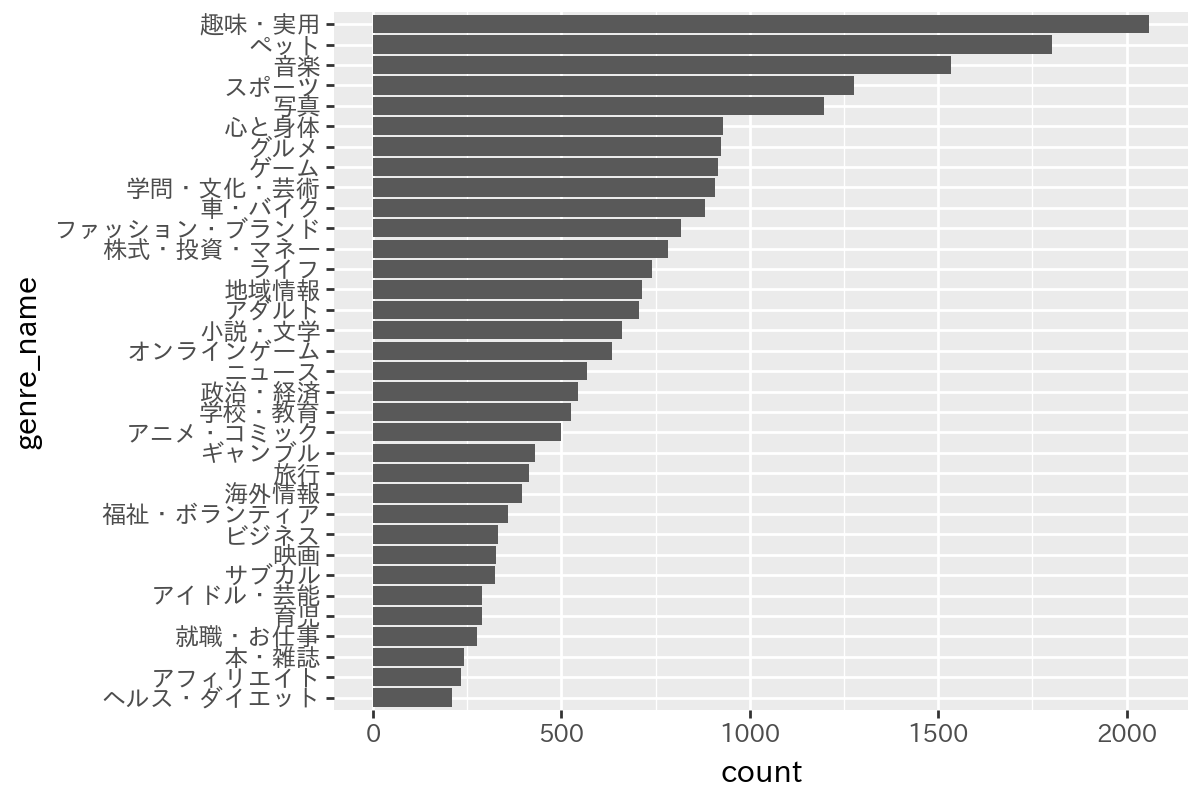

In [6]:
# 記事数 < 200 は除外
genre_counts = df["genre_name"].value_counts()
indices = np.where(genre_counts < 200)[0]
small_genres = genre_counts.iloc[indices].keys().values
df = df.query("genre_name not in @small_genres")

# 日記とブログも中性的なので除外
neutral_genres = ("日記", "ブログ")
df = df.query("genre_name not in @neutral_genres")

# 残ったジャンルの記事数をプロット
genre_name_list = df["genre_name"].value_counts().index.tolist()[::-1]

(
    ggplot(df, aes(x='genre_name'))
    + geom_bar()
    + scale_x_discrete(limits=genre_name_list)
    + theme(text=element_text(family='IPAexGothic'), figure_size=(6, 4))
    + coord_flip()
)

In [7]:
X = df['tokens'].values
y = df['genre_name'].values

出現回数上位 100
[('こと', 46306), ('する', 42939), ('いる', 42502), ('12', 38364), ('さん', 28285), ('よう', 27403), ('2024', 23763), ('なっ', 22617), ('ある', 22394), ('あり', 21347), ('url', 20243), ('10', 18576), ('そう', 16627), ('なり', 16143), ('なる', 15153), ('https', 15080), ('これ', 14371), ('11', 13570), ('もの', 13427), ('the', 13164), ('それ', 12947), ('てる', 12880), ('でき', 12817), ('ない', 12793), ('__', 12080), ('思い', 11035), ('ください', 10883), ('com', 10800), ('30', 10559), ('いい', 10456), ('時間', 10411), ('れる', 10250), ('以上', 10175), ('ため', 9590), ('20', 9572), ('to', 9503), ('自分', 9468), ('ブログ', 9444), ('期間', 9399), ('www', 9371), ('記事', 9258), ('id', 8929), ('感じ', 8795), ('15', 8667), ('思っ', 8533), ('られ', 8344), ('あっ', 8069), ('24', 8014), ('たち', 7803), ('日本', 7452), ('おり', 7384), ('17', 7330), ('01', 7313), ('00', 7258), ('ちゃん', 7191), ('できる', 7189), ('http', 7171), ('18', 7165), ('16', 7104), ('こちら', 7060), ('25', 7022), ('13', 7003), ('お願い', 6988), ('ここ', 6915), ('今日', 6881), ('内容', 6828), ('ところ', 6730)

,x
count,260936.000000
mean,22.937111
std,291.894464
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,46306.000000


/root/.cache/pypoetry/virtualenvs/datasets-xcsZ-3kG-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/root/.cache/pypoetry/virtualenvs/datasets-xcsZ-3kG-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


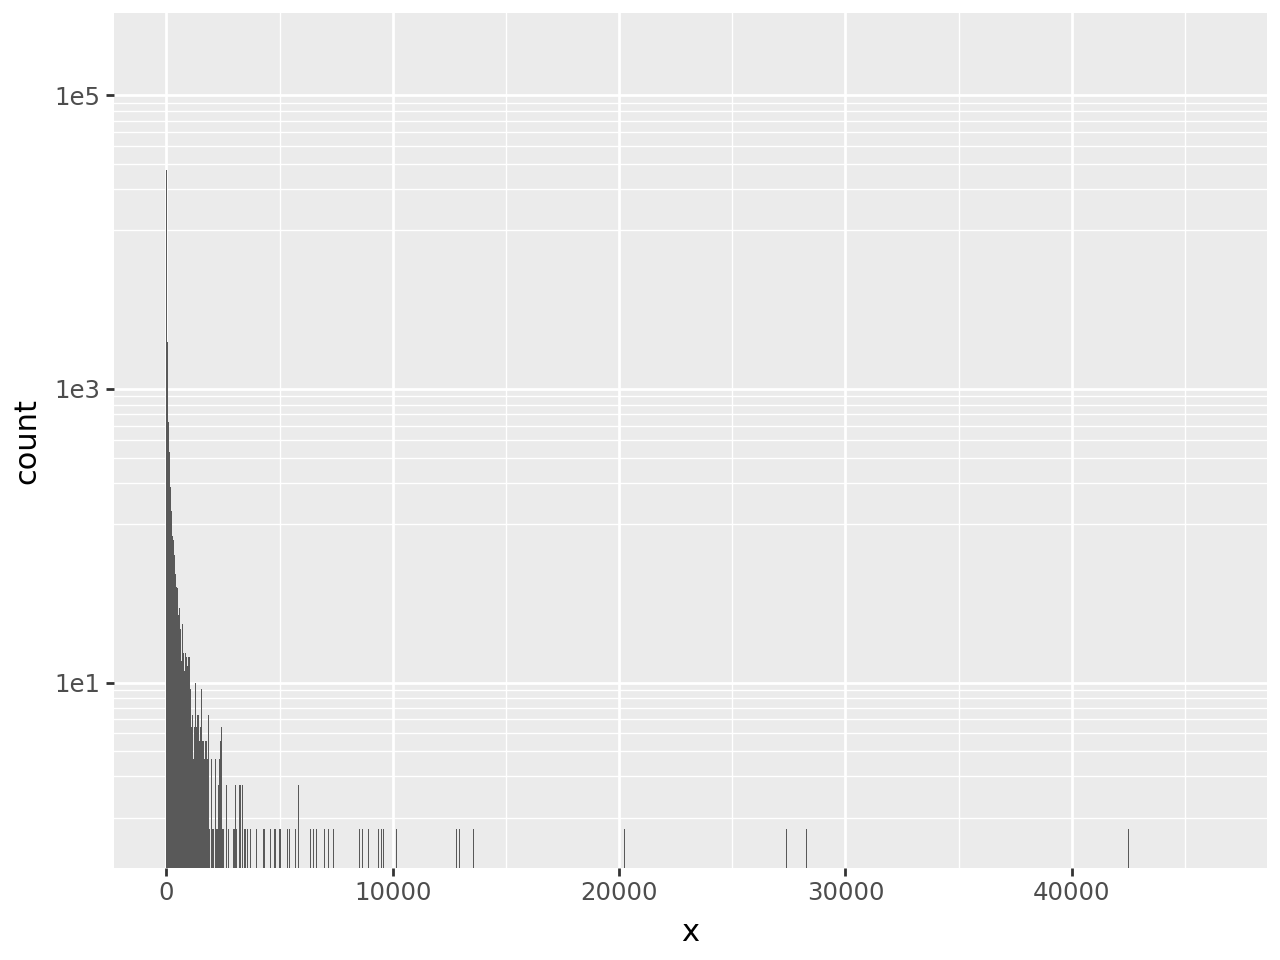

In [8]:
# データセット全体の単語出現頻度の分布
cv = CountVectorizer(lowercase=True, max_df=1.0, min_df=1, max_features=None)
X_all = cv.fit_transform(X)

# 語彙
vocabs = cv.get_feature_names_out()
# 単語出現頻度
freqs = np.array(X_all.sum(axis=0).tolist()[0])

# 出現回数上位 100
print("出現回数上位 100")
print([(w, c) for w, c in zip(vocabs[np.argsort(freqs)[-100:]][::-1], np.array(sorted(freqs)[-100:][::-1]))])

# 出現回数下位 100
print("出現回数下位 100")
print([(w, c) for w, c in zip(vocabs[np.argsort(freqs)[:100]], np.array(sorted(freqs)[:100]))])


# 単語出現頻度のヒストグラムをプロット
plot_df = pd.DataFrame({"x": freqs})
display(plot_df.describe())
(
    ggplot(plot_df, aes(x="x"))
        + geom_histogram(binwidth=10)
        + scale_y_log10()
)

出現回数上位 100
[('する', 10683), ('いる', 10289), ('こと', 9995), ('よう', 9021), ('なっ', 8688), ('ある', 8240), ('12', 8057), ('あり', 7926), ('なり', 7396), ('なる', 6585), ('そう', 6493), ('記事', 6002), ('これ', 5949), ('さん', 5943), ('ない', 5515), ('もの', 5493), ('2024', 5327), ('ブログ', 5288), ('でき', 5252), ('10', 5192), ('それ', 4959), ('思い', 4920), ('ください', 4856), ('時間', 4804), ('れる', 4735), ('いい', 4657), ('思っ', 4427), ('感じ', 4425), ('あっ', 4367), ('ため', 4244), ('られ', 4185), ('関連', 4172), ('てる', 4061), ('11', 4035), ('今日', 3936), ('おり', 3853), ('お願い', 3851), ('こちら', 3834), ('ここ', 3800), ('自分', 3786), ('ところ', 3678), ('今回', 3522), ('良い', 3472), ('できる', 3462), ('30', 3427), ('もう', 3422), ('20', 3265), ('くれ', 3235), ('15', 3227), ('行っ', 3208), ('少し', 3144), ('今年', 3137), ('author', 3024), ('どう', 2989), ('以上', 2958), ('たち', 2952), ('やっ', 2893), ('参加', 2833), ('思う', 2756), ('18', 2709), ('ちょっと', 2707), ('最後', 2683), ('なく', 2682), ('いつも', 2640), ('よく', 2629), ('写真', 2599), ('まだ', 2589), ('17', 2586), ('言っ', 2548), ('考え

,x
count,260936.000000
mean,12.137532
std,105.276078
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,10683.000000


/root/.cache/pypoetry/virtualenvs/datasets-xcsZ-3kG-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/root/.cache/pypoetry/virtualenvs/datasets-xcsZ-3kG-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


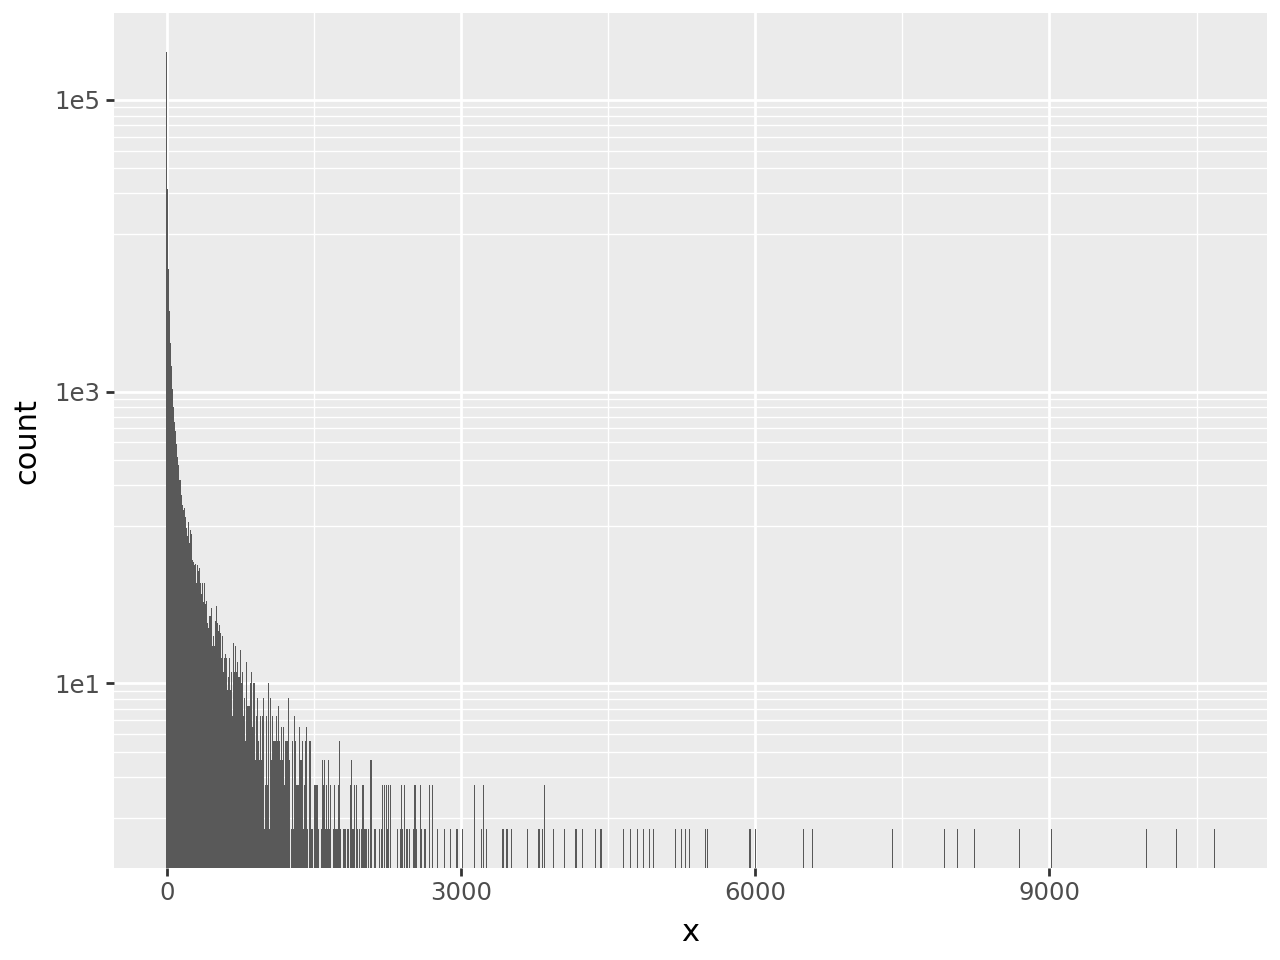

In [9]:
# データセット全体の文書出現頻度の分布
cv = CountVectorizer(binary=True, lowercase=True, max_df=1.0, min_df=1, max_features=None)
X_all = cv.fit_transform(X)

# 語彙
vocabs = cv.get_feature_names_out()
# 文書出現頻度
freqs = np.array(X_all.sum(axis=0).tolist()[0])

# 出現回数上位 100
print("出現回数上位 100")
print([(w, c) for w, c in zip(vocabs[np.argsort(freqs)[-100:]][::-1], np.array(sorted(freqs)[-100:][::-1]))])

# 出現回数下位 100
print("出現回数下位 100")
print([(w, c) for w, c in zip(vocabs[np.argsort(freqs)[:100]], np.array(sorted(freqs)[:100]))])

# 文書出現頻度のヒストグラム
plot_df = pd.DataFrame({"x": freqs})
display(plot_df.describe())
(
    ggplot(plot_df, aes(x="x"))
        + geom_histogram(binwidth=10)
        + scale_y_log10()
)

In [10]:
# 同じラベルの割合で分割する関数
def uniform_kfold(y, n_splits=3):
    np.random.seed(1234)

    labels = list(set(y))
    n_labels = len(labels)

    folds = [[[] for _ in range(n_labels)] for _ in range(n_splits)]

    for label in list(set(y)):
        label_count = list(y).count(label)
        label_indices = [i for i, y_i in enumerate(y) if y_i == label]
        np.random.shuffle(label_indices)
        for i, idx in enumerate(label_indices):
            folds[i % n_splits][labels.index(label)].append(idx)

    for n in range(n_splits):
        train_indices = reduce(add, [reduce(add, indices) for i, indices in enumerate(folds) if i != n])
        test_indices = reduce(add, folds[n])
        yield train_indices, test_indices

In [11]:
data = [(train_indices, test_indices) for (train_indices, test_indices) in uniform_kfold(y, n_splits=3)]

def plot_kfold(data):
    fig = make_subplots(rows=len(data), cols=1, shared_xaxes=True, vertical_spacing = 0.03)
    for i, (train_indices, test_indices) in enumerate(data):
        fig.add_trace(go.Histogram(name='train', x=df.iloc[train_indices]["genre_name"].values, marker_color="blue"), row=i+1, col=1)
        fig.add_trace(go.Histogram(name='test', x=df.iloc[test_indices]["genre_name"].values, marker_color="red"), row=i+1, col=1)
    fig.update_layout(height=1000, width=1000, barmode='group', margin=dict(t=20, b=0, l=10, r=10), showlegend=False)
    fig.update_traces(opacity=0.5)
    fig.show()

plot_kfold(data)

In [12]:
kf = uniform_kfold(y, n_splits=3)
train_indices, test_indices = next(kf)

# 10　<= 単語の出現文書数 <= 文書数*0.3
cv = CountVectorizer(lowercase=True, max_df=0.3, min_df=10, max_features=None)
#cv = TfidfVectorizer(lowercase=True, max_df=0.3, min_df=10, max_features=None)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

print(X_train.shape, y_test.shape)

(15810, 23582) (7921,)


In [13]:
vocabs = cv.get_feature_names_out()

# 出現回数上位 5０
print([(w, c) for w, c in zip(vocabs[np.argsort(X_train.sum(axis=0))[-50:]][::-1], np.array(sorted(X_train.sum(axis=0))[-50:][::-1]))])

# 出現回数下位 50
print([(w, c) for w, c in zip(vocabs[np.argsort(X_train.sum(axis=0))[:50]], np.array(sorted(X_train.sum(axis=0))[:50]))])

[('さん', 18207), ('2024', 15818), ('10', 12553), ('url', 11087), ('そう', 10900), ('なる', 9801), ('これ', 9513), ('11', 9019), ('もの', 8870), ('https', 8769), ('でき', 8767), ('the', 8363), ('ない', 8210), ('それ', 8172), ('てる', 8037), ('期間', 7805), ('以上', 7708), ('__', 7608), ('ください', 7592), ('30', 7396), ('思い', 6967), ('時間', 6898), ('com', 6805), ('いい', 6692), ('れる', 6591), ('20', 6470), ('自分', 6462), ('ため', 6414), ('ブログ', 6286), ('id', 6150), ('記事', 6073), ('15', 5978), ('感じ', 5816), ('www', 5630), ('to', 5587), ('思っ', 5573), ('られ', 5480), ('01', 5323), ('あっ', 5320), ('内容', 5177), ('たち', 5116), ('24', 5110), ('日本', 4976), ('18', 4793), ('おり', 4781), ('16', 4773), ('25', 4735), ('できる', 4719), ('お願い', 4719), ('http', 4701)]
[('恋しい', 10), ('転び', 10), ('卑劣', 10), ('醸し出す', 10), ('出向く', 10), ('騒ぐ', 10), ('山の上', 10), ('複写', 10), ('既設', 10), ('白湯', 10), ('ユニバーサル', 10), ('方程式', 10), ('濁っ', 10), ('屈し', 10), ('788', 10), ('居城', 10), ('おろそか', 10), ('居候', 10), ('遺構', 10), ('えよ', 10), ('とろり', 10), ('濃縮', 10),

In [14]:
kf = uniform_kfold(y, n_splits=3)
train_indices, test_indices = next(kf)

# 10　<= 単語の出現文書数 <= 文書数*0.3
cv = CountVectorizer(binary=True, lowercase=True, max_df=0.3, min_df=10, max_features=None)
#cv = TfidfVectorizer(lowercase=True, max_df=0.3, min_df=10, max_features=None)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

print(X_train.shape, y_test.shape)

(15810, 23582) (7921,)


In [15]:
clf = OneVsRestClassifier(LogisticRegression(n_jobs=multiprocessing.cpu_count()-1, verbose=False))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [16]:
print("Accuracy Score        :", accuracy_score(y_test, y_pred))
print("Classification Report :\n", classification_report(y_test, y_pred))

Accuracy Score        : 0.6545890670369903
Classification Report :
               precision    recall  f1-score   support

     アイドル・芸能       0.74      0.53      0.62        96
        アダルト       0.71      0.66      0.69       236
    アニメ・コミック       0.61      0.51      0.55       166
     アフィリエイト       0.84      0.54      0.66        78
    オンラインゲーム       0.78      0.73      0.75       212
       ギャンブル       0.90      0.77      0.83       144
         グルメ       0.62      0.69      0.65       308
         ゲーム       0.70      0.60      0.65       306
        サブカル       0.83      0.54      0.65       108
        スポーツ       0.68      0.73      0.70       426
        ニュース       0.51      0.60      0.55       190
        ビジネス       0.77      0.50      0.61       111
 ファッション・ブランド       0.66      0.79      0.72       273
   ヘルス・ダイエット       0.81      0.56      0.66        70
         ペット       0.65      0.81      0.72       601
         ライフ       0.50      0.45      0.48       247
          写真 

In [17]:
y_preds, y_trues = [], []

for n, (train_indices, test_indices) in enumerate(uniform_kfold(y, n_splits=3)):
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    print(f'CV.{n} #Train={len(X_train)} #Test={len(X_test)}')

    cv = CountVectorizer(binary=True, lowercase=True, max_df=0.3, min_df=10, max_features=8000)

    X_train = cv.fit_transform(X_train).toarray()
    X_test = cv.transform(X_test).toarray()

    clf = OneVsRestClassifier(LogisticRegression(n_jobs=multiprocessing.cpu_count()-1, verbose=False))
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    y_preds.extend(y_pred)
    y_trues.extend(y_test)

CV.0 #Train=15810 #Test=7921
CV.1 #Train=15822 #Test=7909
CV.2 #Train=15830 #Test=7901


In [18]:
print("Accuracy Score        :", accuracy_score(y_trues, y_preds))
print("Classification Report :\n", classification_report(y_trues, y_preds))

Accuracy Score        : 0.6312418355737222
Classification Report :
               precision    recall  f1-score   support

     アイドル・芸能       0.76      0.51      0.61       288
        アダルト       0.70      0.61      0.65       706
    アニメ・コミック       0.58      0.46      0.51       498
     アフィリエイト       0.82      0.52      0.63       233
    オンラインゲーム       0.76      0.66      0.70       634
       ギャンブル       0.92      0.80      0.86       430
         グルメ       0.61      0.64      0.62       924
         ゲーム       0.64      0.62      0.63       916
        サブカル       0.70      0.50      0.59       324
        スポーツ       0.65      0.73      0.69      1276
        ニュース       0.55      0.63      0.59       569
        ビジネス       0.69      0.46      0.55       331
 ファッション・ブランド       0.70      0.75      0.72       818
   ヘルス・ダイエット       0.81      0.50      0.62       210
         ペット       0.65      0.78      0.71      1801
         ライフ       0.48      0.45      0.47       739
          写真 

In [19]:
from sklearn.naive_bayes import MultinomialNB

y_preds, y_trues = [], []

for n, (train_indices, test_indices) in enumerate(uniform_kfold(y, n_splits=3)):
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    print(f'CV.{n} #Train={len(X_train)} #Test={len(X_test)}')

    cv = CountVectorizer(binary=True, lowercase=True, max_df=0.3, min_df=10, max_features=8000)

    X_train = cv.fit_transform(X_train).toarray()
    X_test = cv.transform(X_test).toarray()

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    y_preds.extend(y_pred)
    y_trues.extend(y_test)

CV.0 #Train=15810 #Test=7921
CV.1 #Train=15822 #Test=7909
CV.2 #Train=15830 #Test=7901


In [20]:
print("Accuracy Score        :", accuracy_score(y_trues, y_preds))
print("Classification Report :\n", classification_report(y_trues, y_preds))

Accuracy Score        : 0.542581433567907
Classification Report :
               precision    recall  f1-score   support

     アイドル・芸能       0.50      0.38      0.43       288
        アダルト       0.80      0.49      0.61       706
    アニメ・コミック       0.54      0.47      0.50       498
     アフィリエイト       0.52      0.39      0.45       233
    オンラインゲーム       0.74      0.58      0.65       634
       ギャンブル       0.67      0.74      0.70       430
         グルメ       0.49      0.70      0.58       924
         ゲーム       0.59      0.55      0.57       916
        サブカル       0.59      0.34      0.43       324
        スポーツ       0.65      0.58      0.61      1276
        ニュース       0.64      0.39      0.48       569
        ビジネス       0.42      0.33      0.37       331
 ファッション・ブランド       0.48      0.72      0.57       818
   ヘルス・ダイエット       0.73      0.41      0.53       210
         ペット       0.51      0.73      0.60      1801
         ライフ       0.54      0.32      0.41       739
          写真  